load libraries

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from numpy.random import uniform
import math
from math import sqrt
import scipy
from keras.utils import np_utils



Using TensorFlow backend.


load data

In [3]:
    batch_size = 500
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Creating our train set and test set, and loading via torch utilities and torchvision
    # Built in methods allow us to directly load the train and test sets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    validset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    validloader = torch.utils.data.DataLoader(trainset, batch_size=10000,
                                              shuffle=True)
    # Method parameters are binary so they allow shuffling + direct access to train/test sets
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size = 10000,
                                             shuffle=False)
    
    

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


preprocess data

load activation functions that take numpy matrices (X) as input and load functions for minibatch

1xn, each unit dot producted with a nx1 set of weights to get one of the n output units

1xn, nxnum_units => 1xnum_units

In [4]:
def relu(z):
   return np.maximum(0,z)

def leaky_relu(x):
   return np.maximum(0.01*x,x)

def sigmoid(x):
  return 1/(1 + np.exp(-x))

def softmax(
  q # C x ... array
  ):
  # z0 = z - np.max(z,0)
  # yh = np.exp(z)
  # yh /= np.sum(yh, 0)
  # return yh
  return scipy.special.softmax(q, axis=1)

def logsumexp(Z# C x N
              ):
  print(Z.shape)
  # or change 1 back to 0 and Z back to Z.T
  Zmax = np.max(Z,1)[None,:]
  print(Zmax.shape)
  lse = Zmax + np.log(np.sum(np.exp(Z - Zmax.T)))
  return lse

def cross_entropy_cost_func(actual, predicted):
  # add regularization?
  # nll = -np.sum(np.dot(predicted, actual.T) - logsumexp(predicted))
  # return nll
  return log_loss(actual, predicted)

def cross_entropy_deriv(yhat, y):
  return yhat-y

def sigmoid_deriv(x):
  f = sigmoid(x)
  return f*(1-f)

def relu_deriv(x):
  alpha = 0
  dx = np.ones_like(x)
  dx[x < 0] = alpha
  return dx

def leaky_relu_deriv(x):
  alpha = 0.01
  dx = np.ones_like(x)
  dx[x < 0] = alpha
  return dx

# generate minibatch indices
def get_batch_indices(num_iter, batch_size):
  batch_indices = []
  for i in range(num_iter):
    shuffle_sequence = np.random.permutation(X.shape[:,0])
    shuffle_sequence = shuffle_sequence[:batch_size]
    batch_indices.append(shuffle_sequence)
  return batch_indices 

def l2_reg(W, lam=1e-3):
    return .5 * lam * np.sum(W * W)

def dl2_reg(W, lam=1e-3):
    return lam * W

def forward(X, weights, bweights, gammas, betas, activation_function, batch_norm = False, avg_mu = None, avg_var = None, train = True):
  N, D = X.shape
  a = []
  a.append(X)
  z = []
  yhat = np.zeros((N, 10))
  mu = [None, None]
  var = [None, None]
  a_norm = [None, None]
  # layer from X to a
  out1 = np.dot(a[0], weights[0]) + bweights[0]
  z.append(out1)
  if(batch_norm):
    if(train):
      out1, mu[0], var[0], a_norm[0] = batch_norm_forward(out1, gammas[0], betas[0])
    else:
      out1, mu[0], var[0], a_norm[0] = batch_norm_forward(out1, gammas[0], betas[0], avg_mu, avg_var, train)
  a.append(activation_function(out1))

  # layer from a(n) to a(n+1)
  if(len(weights) > 2):
    for i in range(len(weights) - 2):
      out = np.dot(a[i+1], weights[i+1]) + bweights[i+1]
      z.append(out)
      a.append(activation_function(out))
  # layer from a to yhat
  out2 = np.dot(a[-1], weights[-1]) + bweights[-1]
  z.append(out2)
  
  # last layer just gives the output rather than appending to a
  yhat = softmax(out2)
  #yhat = out2
  # return some prediction y and a matrix of a's and z's of each unit in the network
  # also return gammas and betas for batch norm
  return yhat, a, z, gammas, betas, mu, var, a_norm

def backward(y, yhat, a, z, gammas, betas, mu, var, weights, bweights, non_lin, non_lin_deriv, batch_norm = False, a_norm=None):
  deltas = [np.zeros(w.shape) for w in weights]
  dbweights = [np.zeros(b.shape) for b in bweights]

  dgammas = [None, None]
  dbetas = [None, None]

  dY = yhat - y

  db = (np.sum(dY, axis=0))
  dW = np.dot(a[-1].T, dY) + dl2_reg(weights[-1])
  dZ = np.dot(dY, weights[-1].T)
  dZ = dZ*non_lin_deriv(a[-1])

  deltas[-1] = dW
  dbweights[-1] = db
  for i in range(2, len(a)):
    db = (np.sum(dZ, axis=0))

    if(batch_norm):
      dZ, dgammas[-i], dbetas[-i] = batch_norm_backward(
        dZ, z[-i], a_norm[-i], mu[-i], var[-i], gammas[-i], betas[-i])
      
    dW = np.dot(a[-i].T, dZ) + dl2_reg(weights[-i])
    dZ = np.dot(dZ, weights[-i].T)
    dZ = dZ*non_lin_deriv(a[-i])
    
    deltas[-i] = dW
    dbweights[-i] = db

  # dbweights2 = (np.sum(dY, axis=0))
  # dW= np.dot(a[1].T, dY) #M x K
  # dZ = np.dot(dY, W.T) #N x M
  # if(batch_norm):
  #   dZ, dgammas[0], dbetas[0] = batch_norm_backward(
  #     dZ, z[0], a_norm[0], mu[0], var[0], gammas[0], betas[0])
  # dbweights1 = (np.sum(dZ, axis=0))
  # dV = np.dot(a[0].T, dZ * non_lin_deriv(a[1])) #D X M

  # deltas.append(dV)
  # deltas.append(dW)
  # dbweights.append(dbweights1)
  # dbweights.append(dbweights2)
  
  return deltas, dbweights, dgammas, dbetas

def batch_norm_forward(a, gamma, beta, avg_mu = None, avg_var = None, train = True):
  eps = 0.00000001
  # compute 
  if (train):
    mu = np.mean(a, axis=0)
    var = np.var(a, axis=0)
  else:
    mu = avg_mu
    var = avg_var

  a_norm = (a - mu) / np.sqrt(var + eps)
  out = gamma * a_norm + beta

  return out, mu, var, a_norm


def batch_norm_backward(d, X, X_norm, mu, var, gamma, beta):
    eps = 0.00001
    N, D = X.shape

    X_mu = X - mu
    std_inv = 1. / np.sqrt(var + eps)

    dX_norm = d * gamma
    dvar = np.sum(dX_norm * X_mu, axis=0) * -.5 * std_inv**3
    dmu = np.sum(dX_norm * -std_inv, axis=0) + dvar * np.mean(-2. * X_mu, axis=0)

    dX = (dX_norm * std_inv) + (dvar * 2 * X_mu / N) + (dmu / N)
    dgamma = np.sum(d * X_norm, axis=0)
    dbeta = np.sum(d, axis=0)

    return dX, dgamma, dbeta

def gradient_check():
  return

def accuracy_score(X, y, weights, bweights, gammas, betas, activation_function, batch_norm = False, avg_mu = None, avg_var = None):
  total, D = X.shape
  correct = 0.0
  # make predictions using a forward pass on all X
  # for i in range(total): # iterate over all instances
  #   yhat = forward(X[i, :], weights, gammas, betas, activation_function, batch_norm, avg_mu, avg_var, False)
  #   pred = np.argmax(yhat)
  #   actual = np.argmax(y[i])
  #   if(pred == actual):
  #     correct += 1   # if the prediction is correct then we add to our count

  yhat, a, z, gammas, betas, mu, var, a_norm = forward(X, weights, bweights, gammas, betas, activation_function, batch_norm, avg_mu, avg_var, False)
  pred = np.argmax(yhat, axis = 1)
  actual = np.argmax(y, axis = 1)
  compare = (pred==actual)
  correct = np.sum(compare)
  return float(correct/total)

# randomly initialize weights
def rand_init(num_layers, num_units, zero = False, bias = False):
  epsilon = 0.3
  weights = []
  weights1 = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(6/(3072+num_units)), 
                                        size = (3072,num_units))
    #uniform(-1/sqrt(3072), 1/sqrt(3072), (3072, num_units))
  weights.append(weights1)
  if(num_layers > 2):
    for i in range(num_layers - 2):
      weightsn = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(6/(num_units+num_units)), 
                                        size = (num_units,num_units))
        #uniform(-1/sqrt(3072), 1/sqrt(3072), (num_units, num_units))
      weights.append(weightsn)

  weights2= np.random.normal(loc=0.0, 
                                        scale = np.sqrt(6/(10+num_units)), 
                                        size = (num_units, 10))
    #uniform(-1/sqrt(3072), 1/sqrt(3072), (num_units, 10))

  weights.append(weights2)
  return weights

def _rescale(X_train):
        """Rescale pixel values
           Note 255 - white
           Note 0 - black
           1-244- Some sort of grey
           with 0 to 1 - 1 is white 0 is black
        """
        return X_train.astype('float32')/255

def _one_hot_encode(y_train):
    """ One hot_encode_outputs"""
    return np_utils.to_categorical(y_train,10)

run minibatch gradient descent

In [0]:
# batch_size is the number of instances in each iteration of gradient descent
# num_layers is the number of layers in the MLP
# num_units is the number of units in each hidden layer (# input features = 3072)
# lr is the learning rate
# non_lin can be relu or sigmoid
def mini_batch_grad_desc(num_layers, batch_size, num_epochs, num_units, 
                         non_lin, non_lin_deriv, 
                         num_iter, lr=0.001, batch_norm = False):
  # randomly initialize weights
  random.seed(222)
 
  weights = rand_init(num_layers, num_units)
  bweights = []
  bweights.append(np.zeros((1,num_units)))
  if(num_layers > 2):
    for i in range(num_layers - 2):
      bweights.append(np.zeros((1, num_units)))
  bweights.append(np.zeros((1,10)))

  gammas = []
  gammas.append(np.ones((1,num_units)))
  if(num_layers > 2):
    for i in range(num_layers - 2):
      gammas.append(np.ones((1, num_units)))
  gammas.append(np.ones((1,10)))
  betas = []
  betas.append(np.ones((1,num_units)))
  if(num_layers > 2):
    for i in range(num_layers - 2):
      betas.append(np.zeros((1, num_units)))
  betas.append(np.zeros((1,10)))


  overall_mu = 0
  overall_var = 0

  Vw = [np.ones(x.shape) for x in weights]
  Vb = [np.ones(x.shape) for x in bweights]

  beta = 0.9

  # generate minibatch indices
  # batch_indices = get_batch_indices(num_iter, batch_size)
  
  # gradient descent on minibatches
  train_acc = []
  test_acc = []

  for epoch in range(num_epochs):
    dataiter = iter(trainloader)
    
    for iteration in range(num_iter):
      X_batch, y_batch = dataiter.next()
      X_batch = np.reshape(np.array(X_batch), (batch_size, 3072))
      y_batch = np.reshape(np.array(y_batch), (batch_size, 1))
      y_batch = label_binarize(y_batch, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

      cum_deltas = rand_init(num_layers, num_units, zero = True)
      cum_dgammas = rand_init(num_layers, num_units, zero = True)
      cum_dbetas = rand_init(num_layers, num_units, zero = True)
      cum_mu = 0
      cum_var = 0

      # for i in range(batch_size):
        # forward prop
      yhat, a, z, gammas, betas, mu, var, a_norm = forward(X_batch, weights, bweights, gammas, betas, non_lin, batch_norm)        
        # backprop to get small deltas

      deltas, dbweights, dgammas, dbetas = backward(y_batch, yhat, a, z, gammas, betas, mu, var, weights, bweights,
                                           non_lin, non_lin_deriv, batch_norm, a_norm)
        # add to accumulators
      cum_deltas = deltas
      if(batch_norm):
        cum_dgammas =  dgammas
        cum_dbetas =  dbetas
        cum_mu =  mu[0]
        cum_var =  var[0]

      # compute the jacobian (avg_deltas) and other derivatives
      # print to compare with gradient check

      avg_deltas = [c/batch_size for c in cum_deltas]
      avg_dbweights = [c/batch_size for c in dbweights]

      if(batch_norm):
        avg_dgammas = cum_dgammas[0]/batch_size 
        avg_dbetas = cum_dbetas[0]/batch_size
        # compute average mu and var to use for accuracy scoring
        avg_mu = cum_mu/batch_size 
        avg_var = cum_var/batch_size

        # average mu and var thus far (considering all batches)
        overall_mu = (overall_mu + avg_mu)
        overall_var = (overall_var + avg_var)
      # can then do gradient checking (just once)
      # print gradient checking output 

      # update weights (use jacobian, mus, vars)
      Vw = [(1 - beta) * d + beta * V for (d, V) in zip(avg_deltas, Vw)]
      Vb = [(1 - beta) * d + beta * V for (d, V) in zip(avg_dbweights, Vb)]
      # weights = [w-lr*g for (w,g) in zip(weights, Vw)]
      # bweights = [w-lr*g for (w,g) in zip(weights, Vb)]

      weights = [w-lr*V for (w,V) in zip(weights, Vw)]
      bweights = [w-lr*V for (w,V) in zip(bweights, Vb)]


      if(batch_norm):
        gammas[0] = gammas[0] - lr*avg_dgammas[0]
        #gammas[1] = gammas[1] - lr*avg_dgammas[1]
        betas[0] = betas[0] - lr*avg_dbetas[0]
        #betas[1] = betas[1] - lr*avg_dbetas[1]

      # print cost after every 10 batches (iterations)
      if(iteration == 99):
        print("iteration number", iteration, "has cost", cross_entropy_cost_func(y_batch, yhat))
        # print(yhat[5])
          #or z[-1] instead of yhat?
   
    score_mu = 0
    score_var = 0
    if(batch_norm):
      score_mu = overall_mu[0]/(num_epochs)
      score_var = overall_var[0]/(num_epochs)

    X_test, y_test = iter(testloader).next()
    X_test = np.reshape(np.array(X_test), (10000, 3072))
    y_test = np.reshape(np.array(y_test), (10000, 1))
    y_test = label_binarize(y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    X_valid, y_valid = iter(validloader).next()
    X_valid = np.reshape(np.array(X_valid), (1000, 3072))
    y_valid = np.reshape(np.array(y_valid), (1000, 1))
    y_valid = label_binarize(y_valid, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


    train_acc_score = accuracy_score(X_valid, y_valid, weights, bweights, gammas, betas, non_lin, batch_norm, score_mu, score_var)
    test_acc_score = accuracy_score(X_test, y_test, weights, bweights, gammas, betas, non_lin, batch_norm, score_mu, score_var)
    print("epoch", epoch, "train accuracy:", train_acc_score, "test accuracy:", test_acc_score)
    train_acc.append(train_acc_score)
    test_acc.append(test_acc_score)
  # plot train_acc_score and test_acc_score over the number of epochs
  fig, ax = plt.subplots()
  ax.plot(np.linspace(1, num_epochs, num=num_epochs), train_acc, label = 'train', marker='o', drawstyle="steps-post")
  ax.plot(np.linspace(1, num_epochs, num=num_epochs), test_acc, label = 'test', marker='o', drawstyle="steps-post")
  ax.set_xlabel("epochs")
  ax.set_ylabel("accuracy")
  ax.set_title("Accuracy vs number of epochs")
  plt.show()
  # do final test accuracy???


3 0.001
iteration number 99 has cost 2.3111648684720087
epoch 0 train accuracy: 0.082 test accuracy: 0.0846
iteration number 99 has cost 2.302687946557233
epoch 1 train accuracy: 0.098 test accuracy: 0.0854
iteration number 99 has cost 2.275633556595132
epoch 2 train accuracy: 0.123 test accuracy: 0.1179
iteration number 99 has cost 2.267633587889724
epoch 3 train accuracy: 0.112 test accuracy: 0.1191
iteration number 99 has cost 2.2929904902798652
epoch 4 train accuracy: 0.121 test accuracy: 0.1192
iteration number 99 has cost 2.292880935992459
epoch 5 train accuracy: 0.165 test accuracy: 0.15
iteration number 99 has cost 2.279163892637614
epoch 6 train accuracy: 0.138 test accuracy: 0.1486
iteration number 99 has cost 2.2683933852723395
epoch 7 train accuracy: 0.14 test accuracy: 0.1481
iteration number 99 has cost 2.2748741141491884
epoch 8 train accuracy: 0.162 test accuracy: 0.148
iteration number 99 has cost 2.284124296290558
epoch 9 train accuracy: 0.156 test accuracy: 0.1479
it

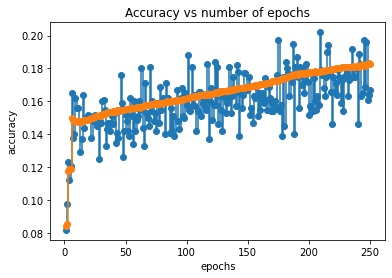

In [6]:
#mini_batch_grad_desc(500, 50, 100, sigmoid, sigmoid_deriv, 100, lr=0.001, batch_norm = False)

print(3, 0.001)
 
mini_batch_grad_desc(3, 500, 250, 500, 
                         sigmoid, sigmoid_deriv, 
                         100, lr=0.001, batch_norm = False)

In [0]:
  X = np.zeros((3072))
  num_features, = X.shape
  weights = np.zeros((3, 4000, 3999))
  num_layers, num_units_in, num_units_out = weights.shape
  a = np.ones((num_layers-1, num_units_in))
  z = np.zeros((num_layers-1, num_units_out))
  y = np.zeros(10)
  deltas = np.zeros((num_layers+1, num_units_in))
  mu = np.zeros(num_layers)
  var = np.zeros(num_layers)
  # layer 0
  out = np.dot(X, weights[0,0:num_features,:])
  print(out)
  ypre = np.dot(a[num_layers-2,:], weights[num_layers-1,:,:10])
  print(ypre.shape)
  y = np.exp(ypre) / np.sum(np.exp(ypre), axis=0) 
  print(y.shape)
  y = softmax(X)
  print(y.shape)
  print('relu', relu_deriv(z[-1, :]).shape)
  i=1
  non_lin_deriv = relu_deriv
  s = np.dot(deltas[-i+1, :], (weights[-i, :,:]))*non_lin_deriv(z[-i, :])
  q = np.dot(s, np.transpose(a[-i, 1:]))
  print(s.shape)
  print(q.shape)

[0. 0. 0. ... 0. 0. 0.]
(10,)
(10,)
(3072,)
relu (3999,)
(3999,)
()


In [0]:
x = np.array([1,1])
w = np.array([[2, 3, 4],
             [5, 6, 7]])
yhat = np.array([[0, 1, 2], 
                 [3, 4, 1]])
y = np.array([[0, 1, 2], 
                 [3, 4, 5]])

print(np.max(yhat, axis=1))
print(np.max(y, axis = 1))


[2 4]
[2 5]


In [0]:
# print(1)
# mini_batch_grad_desc(500, 50, 100, 
#                          sigmoid, sigmoid_deriv, 
#                          100, lr=0.001, batch_norm = False)
print(2)
mini_batch_grad_desc(10, 50, 4000, 
                         relu, relu_deriv, 
                         100, lr=0.001, batch_norm = False)
print(3)
mini_batch_grad_desc(500, 50, 200, 
                         leaky_relu, leaky_relu_deriv, 
                         100, lr=0.001, batch_norm = False)
print(4)
mini_batch_grad_desc(500, 50, 200, 
                         relu, relu_deriv, 
                         100, lr=0.001, batch_norm = False)
print(11)
mini_batch_grad_desc(500, 50, 200, 
                         sigmoid, sigmoid_deriv, 
                         100, lr=0.01, batch_norm = False)
print(12)
mini_batch_grad_desc(500, 50, 200, 
                         relu, relu_deriv, 
                         100, lr=0.01, batch_norm = False)
print(13)
mini_batch_grad_desc(500, 50, 200, 
                         leaky_relu, leaky_relu_deriv, 
                         100, lr=0.01, batch_norm = False)
print(14)
mini_batch_grad_desc(500, 50, 200, 
                         relu, relu_deriv, 
                         100, lr=0.01, batch_norm = False)

2
iteration number 1 has cost 18.282993470788476
weights [-0.03887523  0.09063869  0.04424523 -0.14081023]
iteration number 99 has cost 10.802095363596887
weights [-0.04639922  0.08291351  0.03598628 -0.14761918]
epoch 0 train accuracy: 0.169 test accuracy: 0.1718
iteration number 1 has cost 17.97967195355303
weights [-0.04640677  0.08292818  0.03596133 -0.14762935]
iteration number 99 has cost 14.537182014251737
weights [-0.04625677  0.08263937  0.03602084 -0.14702994]
epoch 1 train accuracy: 0.159 test accuracy: 0.1568
iteration number 1 has cost 13.999704699027864
weights [-0.04627998  0.08262892  0.03601482 -0.14702095]
iteration number 99 has cost 22.204537656124238
weights [-0.04598296  0.08159936  0.0358726  -0.14627387]
epoch 2 train accuracy: 0.204 test accuracy: 0.2027
iteration number 1 has cost 22.792349363270652
weights [-0.04594935  0.08153604  0.03587556 -0.14625695]
iteration number 99 has cost 21.623265677209005
weights [-0.04576767  0.08062146  0.03570961 -0.14529067]

KeyboardInterrupt: ignored